In [3]:
import logging

# Set up logging
logging.basicConfig(filename='debug.log', level=logging.DEBUG)

# Then in your code...
def some_function():
    logging.info('Starting function...')
    # ...code...
    logging.info('Finished function.')

In [4]:
%matplotlib inline

from importlib import reload
from helper_funcs import *
from make_models2 import *

# Make tqdm work for notebooks
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import pickle
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


# print(now()-t00)

/mmfs1/data/liacz/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [10]:
import torch
torch.cuda.empty_cache()

# Load data

In [1]:
import numpy as np
import os
indir = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/array_brains'
BRAIN_data = np.load(os.path.join(indir, "arr_combine/BRAIN_data.npy"))
DX_subs = np.load(os.path.join(indir, "arr_combine/DX_subs.npy"))
TD_subs = np.load(os.path.join(indir, "arr_combine/TD_subs.npy"))

In [5]:
# #BRAIN_data = np.array(BRAIN_data)
# nsubs = BRAIN_data.shape[0]
# print([arr.shape for arr in [BRAIN_ds, BRAIN_subs, BRAIN_data]])
# print(nsubs)
# print((BRAIN_data.min(),BRAIN_data.max()))

In [6]:
# df = pd.read_csv('/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/legend.csv')
# BI_subs = df.loc[df['bilingualism'].values == 1.0, 'ds_par_id']
# MO_subs = df.loc[df['bilingualism'].values == 0.0, 'ds_par_id']
# BRAIN_ds_subs = [BRAIN_ds[i]+'_'+BRAIN_subs[i] for i in range(0,len(BRAIN_subs))]
# BI_subs = [sub in BI_subs.to_list() for sub in BRAIN_ds_subs]
# MO_subs = [sub in MO_subs.to_list() for sub in BRAIN_ds_subs]

In [7]:
# print(BI_subs.count(True))
# print(MO_subs.count(True))

NameError: name 'BI_subs' is not defined

In [2]:
# TD_subs = BRAIN_data[MO_subs,:,:,:] # Data of Monolinguals 
# DX_subs = BRAIN_data[BI_subs,:,:,:] # Data of Bilinguals
print(TD_subs.shape)
print(DX_subs.shape)

(1083, 64, 64, 64)
(664, 64, 64, 64)


# train VAE

In [12]:
train_vae = True

In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [14]:
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [15]:
if train_vae:
    
    latent_dim = 32
    batch_size = 16
    disentangle = False
    gamma = 100

    encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64,64,64,1), 
                                            latent_dim=32, 
                                            batch_size = batch_size, 
                                            disentangle=True,
                                            gamma=gamma,
                                            kernel_size = 3,
                                            filters = 48,
                                            intermediate_dim = 128,
                                            nlayers = 2,
                                            bias=True)


    loss = list()
    fn = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/VAE/VAE_weights'
        
    print(fn)

/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/VAE/VAE_weights


In [16]:
encoder.summary(line_length=100)

Model: "encoder"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 encoder_input (InputLayer)      [(None, 64, 64, 64,   0           []                               
                                 1)]                                                                
                                                                                                    
 conv3d (Conv3D)                 (None, 32, 32, 32, 9  2688        ['encoder_input[0][0]']          
                                 6)                                                                 
                                                                                                    
 conv3d_1 (Conv3D)               (None, 16, 16, 16, 1  497856      ['conv3d[0][0]']                 
                                 92)                                      

In [17]:
decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 z_sampling (InputLayer)                     [(None, 32)]                            0              
                                                                                                    
 dense_1 (Dense)                             (None, 128)                             4224           
                                                                                                    
 dense_2 (Dense)                             (None, 786432)                          101449728      
                                                                                                    
 reshape (Reshape)                           (None, 16, 16, 16, 192)                 0              
                                                                          

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

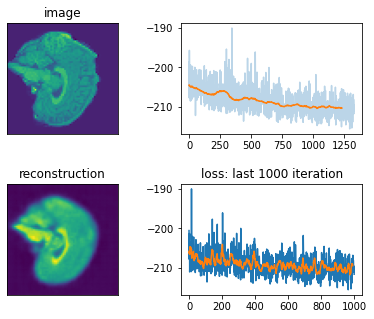

100%|█████████▉| 1995/1999 [39:41<00:04,  1.15s/it]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 1996/1999 [39:42<00:03,  1.07s/it]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 1997/1999 [39:42<00:02,  1.01s/it]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 1998/1999 [39:43<00:00,  1.03it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 1999/1999 [39:44<00:00,  1.19s/it]


In [18]:
nbatches = 2000
if train_vae:
    for i in tqdm(range(1,nbatches)):    
        
        batch_idx = np.random.randint(low=0,high=BRAIN_data.shape[0],size=batch_size)
        data_batch = BRAIN_data[batch_idx,:,:,:]
        
        history = vae.train_on_batch(data_batch);
        mse = ((data_batch-vae.predict(data_batch)[:,:,:,:,0])**2).mean()
        loss.append(history);
        
        if np.mod(i,5)==0: # Plot training progress
            im1 = data_batch[0,32,:,:];
            im = vae.predict(data_batch)[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,10)==0: # Save every 10 batches
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)    
        
        if mse < .0005:
            break

# train CVAE

In [19]:
train_cvae = True

In [20]:
if train_cvae:
    
    latent_dim = 16
    batch_size = 16
    beta = 1;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fdir = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/CVAE/'
    fn = 'CVAE_weights'
    
    fn = os.path.join(fdir,fn)
    loss = []

In [21]:
print(fn)

/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/CVAE/CVAE_weights


In [22]:
z_encoder.summary(line_length=100)

Model: "z_encoder"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 tg_inputs (InputLayer)          [(None, 64, 64, 64,   0           []                               
                                 1)]                                                                
                                                                                                    
 conv3d_2 (Conv3D)               (None, 32, 32, 32, 6  1792        ['tg_inputs[0][0]']              
                                 4)                                                                 
                                                                                                    
 conv3d_3 (Conv3D)               (None, 16, 16, 16, 1  221312      ['conv3d_2[0][0]']               
                                 28)                                    

In [23]:
cvae_decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 z_sampling (InputLayer)                     [(None, 32)]                            0              
                                                                                                    
 dense_6 (Dense)                             (None, 128)                             4224           
                                                                                                    
 dense_7 (Dense)                             (None, 524288)                          67633152       
                                                                                                    
 reshape_1 (Reshape)                         (None, 16, 16, 16, 128)                 0              
                                                                          

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

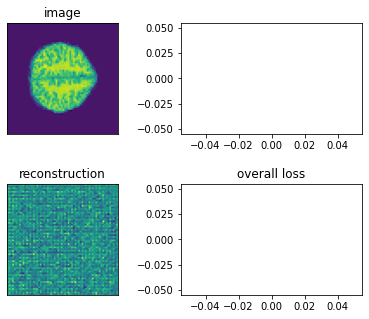

In [24]:
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(BRAIN_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(BRAIN_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

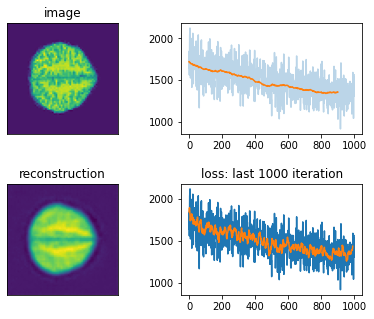

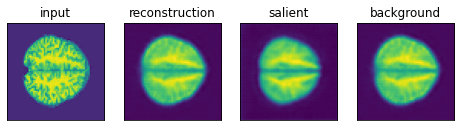

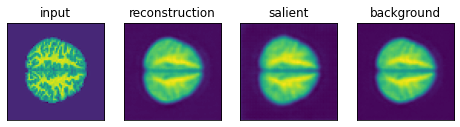

In [ ]:
nbatches = 2000
if train_cvae:
    for i in tqdm(range(1,nbatches)):
        
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
        hist = cvae.train_on_batch([DX_batch,TD_batch]);
        loss.append(hist);
        
        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch]))[:,:,:,:,:,0])**2).mean()

        assert not np.isnan(hist),'loss is NaN - somethings wrong'

        im,im1,ss = cvae_query(BRAIN_data, s_encoder, z_encoder, cvae_decoder); 

        

        if np.mod(i,5)==0: # Plot training progress
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

        if np.mod(i,10)==0: # Save every 10 batches
            cvae.save_weights(fn)
            
        if mse < .0005:
            break

In [1]:
import pickle
import os

path = os.path.expanduser('~/Documents/Bilingualism_CVAE/data/tf_outputs/CVAE/CVAE_weights_loss.pickle')
with open(path, 'rb') as handle:
    loaded_object = pickle.load(handle)

In [2]:
len(loaded_object)

1500

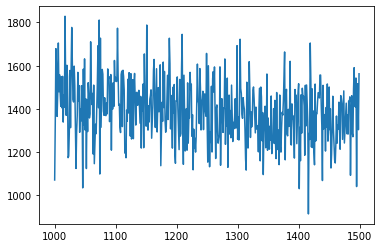

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(1000,len(loaded_object)), loaded_object[1000:])
plt.show()

In [ ]:
# !module list
# !nvidia-smi
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'
# from datetime import datetime;now = datetime.now;t00 = now()
# print(t00)
# # GPU checks
# import tensorflow as tf
# # tf.test.gpu_device_name()
# # tf.test.is_gpu_available()
# tf.test.gpu_device_name()
# import timeit,pickle
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))